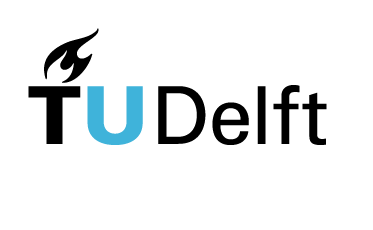

<h1 style="text-align:center"> Take Home Assignment, Series 2, 2023/2024</h1>

<h2><p>Faculty of Electrical Engineering, Mathematics, and Computer Science<br>
Mathematical Methods For Physics: Finite-Element Analysis (AP3001-FE)</p></h2>

Author:
  - Carolina Urzúa Torres
  - Artur Palha (minor updates)
    
Jupyter Notebook:
  - Carolina Urzúa Torres
  - Dani Balagué Guardia
  - Artur Palha
  
## <span style="color:red">DEADLINE</span>
To be submitted **before 17:00 of December 22nd, 2023**, via Brightspace, the report (pdf) and code (ipynb).

## Typesetting
The report must be typeset in either $\LaTeX$ or Word and converted to a pdf file.

## Problem Statement

Let $\Omega \subset \mathbb{R}^2$ be a bounded region with boundary </li>
$\partial\Omega = \Gamma$.
In $\Omega$ we model the membrane of a drum when hit in a specific point ${\bf x}_0\in \Omega$:

$$
   \def\div#1{\text{div}\left(#1\right)}
$$

\begin{equation}
\label{eq1}
-\div{\sigma({\bf x}) \nabla u}  = \delta({\bf x_0}),
\end{equation}

where $u$ represents the displacement of the membrane, and $\sigma({\bf x}) > 0$ is the
stiffness of the membrane. The membrane is clamped into a rigid frame modelled by a given function $g$.

Hence, the boundary conditions read

\begin{equation}
\label{eq2}
 \begin{array}{ll}
   u = g, & \text{ on } \Gamma.
 \end{array}
\end{equation}

<hr style="border: 15px solid #00A6D6;border-radius: 10px">

<h1 style="text-align:center"> Assignment - Part 1 </h1>
<p>(To be answered on paper and submitted through Brightspace)</p>
<br><br>
<ol start="1">
<li> Derive the weak formulation for this boundary value problem.</li>
</ol>


<hr style="border: 2px solid #00A6D6;border-radius: 10px">

<ol start="2">
<li> To solve equation \eqref{eq1} with boundary conditions \eqref{eq2}, we approximate the solution using Galerkin's Method with basisfunctions $\{\phi_j(x,y)\}_{j=1}^n$, where we set $u(x,y) \approx u_n(x,y) = \sum_{j=1}^n c_j \phi_j(x,y)$. Derive the Galerkin Equations. What should be the value of the basis functions $\phi_j(x,y)$ on the boundary? Motivate your answer.</li>
</ol>

<hr style="border: 2px solid #00A6D6;border-radius: 10px">

<ol start="3">
<li> Compute the element local matrix using linear triangular basis functions.</li>
</ol>

<hr style="border: 2px solid #00A6D6;border-radius: 10px">

<ol start="4">
<li> Compute the element local vector using linear triangular basis functions.</li>
</ol>

<hr style="border: 15px solid #00A6D6;border-radius: 10px">

<h2 style="text-align:center"> Assignment - PART 2</h2>
<p>(To be answered in this jupyter notebook and submitted through Brightspace)</p>
<br><br>
Now we turn to the implementation part of the lab assignment. Run the code below until you reach the first question.

In [ ]:
# If we are in google colab we need to do some extra things to have access to
# the dependencies
try:
  import google.colab
  IN_COLAB = True

  # We are in google colab

  # Mount your google drive in google colab
  from google.colab import drive
  drive.mount('/content/drive')

  # Check your Colab temporary path
  !pwd # Returns /content

  # Copy custom module from Google Drive to Colab temporary drive
  # !cp [path of your custom module] [path where you like to copy]
  ! cp -r /content/drive/MyDrive/AP3001_FE/Take_home_assignment_series_2/ /content/
  ! ls /content/Take_home_assignment_series_2/

  # Install dependencies
  ! pip3 install scikit-fem[all]

except:
  # We are not in google colab
  IN_COLAB = False

In [ ]:
#%matplotlib notebook
# Import the libraries needed in order to run the code
import sys
sys.path.append('.resources')

if IN_COLAB:
  # In colab we need to add the dependencies to the search path
  sys.path.append('/content/Take_home_assignment_series_2')

from mesh import *
from tests_lab1 import *
import numpy as np
from scipy.sparse import lil_matrix as sparse_matrix
from scipy.sparse.linalg import spsolve as solve

# Create the mesh
diskMesh = Mesh('circle',None,refinement=2)

# Get the elements: returns an array with the coordinate index of the vertices
element_list = diskMesh.topology_elements

# Returns the list of vertices
p = diskMesh.points.T

# Compute the number of vertices
n = len(p)

# Plot the mesh
ax = diskMesh.draw()

<ol start="5">
<li> Implement the element local matrix derived in Exercise 3.</li>
</ol>


In [ ]:
# The total number of return values of the function should be 3
# Read the function description

def generate_element_matrix(points, element, sig=None, topology=3):

    """ Computes the element matrix for a given element.

        Intputs:
            + points: list of points (NumPy Array)
            + element: the element for which we are constructing the local matrix
            + sig: the function sigma defined in the problem.
            + topology: optional variable corresponding to the number of nodes per element. Default=3

        Output:
            + delta: The double of the area of the element (triangle)
                    (scalar with type 'numpy.float32' or 'numpy.float64')
            + B_mat: Numpy array (matrix) with type 'numpy.float32' or 'numpy.float64'
                     containing the values of alpha, beta, and gamma, for each basis function,
                     phi_{i}, by columns in this order, where the basis functions are given as:
                       phi_{i}(x, y) := \alpha_{i} + \beta_{i} x + \gamma_{i} y
            + L_mat: Numpy array (matrix) with type 'numpy.float32' or 'numpy.float64'
                     containing the local element matrix. """

    ### BEGIN SOLUTION

    # Here we need to compute for each triangle T (element):
    #    L_mat_{i,j} := < \nabla\phi_{i}, \nabla\phi_{j} >_{T, \sigma}
    #                := \int_{T} \nabla\phi_{i} S \nabla\phi_{j}^{\tranpose} dT
    #
    # since S := \sigma \mathbb{I} (\mathbb{I} is the identity matrix) and \sigma
    # is contant, we get the very simple expression:
    #    L_mat_{i,j} = \sigma \int_{T} \nabla\phi_{i} \cdot \nabla\phi_{j} dT
    #
    # This means we need to:
    #   1. Compute the basis \phi_{i}
    #   2. Compute the gradient of the basis \nabla\phi_{i}
    #   3. Compute the integral of the inner product between the gradients of the bases
    #   4. Multiply (3) by constant value sigma
    #
    # The basis are linear, and have the form
    #   \phi_{i}(x, y) := \alpha_{i} + \beta_{i} x + \gamma_{i} y
    # therefore, the gradients will have the simple form
    #   \nabla\phi_{i}(x, y) = [\frac{\partial\phi_{i}}{\partial x}, \frac{\partial\phi_{i}}{\partial y}]
    #                        = [\beta_{i}, \gamma_{i}]
    # Note that the gradients are constant!
    # This means that:
    #    L_mat_{i,j} := < \nabla\phi_{i}, \nabla\phi_{j} >_{T, \sigma}
    #                := \sigma \int_{T} \nabla\phi_{i} \cdot \nabla\phi_{j} dT
    #                 = \sigma \int_{T} (\beta_{i}\beta_{j} + \gamma_{i}\gamma_{j}) dT
    #                 = \sigma A (\beta_{i}\beta_{j} + \gamma_{i}\gamma_{j})

    # 0. We start by computing the area, A, of the triangle (in fact, the double of the area, delta).
    # A known way of computing the double of the area of a triangle given the coordinates of
    # the three vertices is the following:
    #           -       -
    # 2A = det | 1 x1 y1 |
    #          | 1 x2 y2 |
    #          | 1 x3 y3 |
    #           -       -
    # Note that this is a signed area (to use the area, you need to take the absolute value)
    delta_matrix = # ... fill in
    delta = # ... fill in

    # 1. Compute the basis elements \phi_{i}
    # As seen above, the basis elements are fully known once we know the coefficients
    # \alpha_{i}, \beta_{i}, \gamma_{i}, of the basis i, such that we can evaluate
    #   \phi_{i}(x, y) := \alpha_{i} + \beta_{i} x + \gamma_{i} y
    #
    # We can obtain the coefficients in the following way. Each basis function, \phi_{i},
    # is a Lagrange basis function, i.e., if P_{j} := (x_{j}, y_{j}) is a point j of the triangle,
    # then the bases have the following kronecker property:
    #   \phi_{i}(P_{j}) = \delta_{i,j}
    #
    # This means that the bases satisfy the following equation:
    #   -       -     -                                  -     -     -
    #  | 1 x1 y1 |   | \alpha_{1}  \alpha_{2}  \alpha_{3} | = | 1 0 0 |
    #  | 1 x2 y2 |   | \beta_{1}   \beta_{2}   \beta_{3}  |   | 0 1 0 |
    #  | 1 x3 y3 |   | \gamma_{1}  \gamma_{2}  \gamma_{3} |   | 0 0 1 |
    #   -       -     -                                  -     -     -
    #       |                          |
    #       v                          v
    #  delta_matrix                  B_mat
    #
    # By solving this system of equations, we get in B_mat the coefficients
    # that define each basis function.
    B_mat = # ... fill in

    # 2. Compute the gradient of the basis, \nabla\phi_{i}
    # As seen above, since
    #   \phi_{i}(x, y) := \alpha_{i} + \beta_{i} x + \gamma_{i} y
    # then
    #   \frac{\partial\phi_{i}}{\partial x} = \beta_{i}
    dphi_dx = # ... fill in

    # and
    #   \frac{\partial\phi_{i}}{\partial y} = \gamma_{i}
    dphi_dy = # ... fill in

    # 3. Compute the integral of the inner product between the gradients of the bases
    # As seen above, the integral of the inner product between the gradients of the bases
    # is:
    #   L_mat_{i,j} = \sigma A (\beta_{i}\beta_{j} + \gamma_{i}\gamma_{j})
    # The terms \beta_{i}\beta_{j} and \gamma_{i}\gamma_{j} are just kronecker products
    # that numpy already provides, so we can simply use that. Note that we need to transpose
    # dphi_dx to make it a column vector, but if we just use .T, numpy still considers it a
    # row vector, so we need to use .reshape(-1, 1), although apparently complicated it just
    # computes the transpose and returns a column vector.
    # Note we multiply by 0.5*delta instead of A, since delta = 2A (and we already computed delta).
    l_mat = 1.0 # ... fill in

    # 4. Multiply (3) by constant value sigma
    # Now we just get L_mat, by simply multiplying l_mat by \sigma
    if sig is None:
        sigma_value = 0.0
    else:
        # In case sigma is not constant, just take the average of the
        # values at the points of the triangle
        sigma_value = 0.0
        for point_idx in element:
            sigma_value += sig(points[point_idx]) / 3.0

    L_mat = sigma_value * l_mat

    ### END SOLUTION

    return delta, B_mat, L_mat

Now run the tests below.

The following tests just test for the format of your output variables. They do not check if you obtain correct results.

In [ ]:
test_element_matrix(generate_element_matrix,p,element_list)

<hr style="border: 2px solid #00A6D6;border-radius: 10px">

<ol start="6">
<li> Implement the element local vector derived in Exercise 4.</li>
</ol>

In [ ]:
# INSTRUCTIONS: the return value of the function should be a NumPy array of size (topology x 1)
# with type 'float32'. If you have trouble with the size, try reshaping the array!

def generate_element_vector(points,element,delta,B_mat,x0=np.array([0., 0.]),func=None,topology=3):

    """ Generates the local element vector

        Inputs:
            - points: list of points (NumPy Array)
            - element: the element for which we are constructing the local matrix
            - delta: the double of the area of the element (triangle), computed when
                     generating the local matrix
            - B_mat: Numpy array (matrix) containing the values of alpha, beta, and gamma,
                     by columns in this order. This array was computed when generating the
                     local matrix
            - x0: Numpy Array with the coordinates of the point where the delta is evaluated.
                  Default = np.array([0., 0.])
            - func: optional argument. Function for the right-hand side of the PDE.
                    Not needed for this assignment (ignore this input). Default = None
            - topology: optional argument for the number of nodes in an element. Default = 3

        Outputs:
            - L_f_vec: local element vector (NumPy array) with type 'float32'
    """

    # Here we need to compute the following inner product:
    # L_f_vec_{i} := <f, phi_{i}>_{T}
    #             := \int_{T} f \phi_{i} dT
    #
    # The tricky aspect here (but also simplifies things) is that f_{x_{0}}(x, y) := \delta(x - x0, y - y0)
    # this means that:
    # L_f_vec_{i} := \int_{T} f \phi_{i} dT
    #              = \int_{T} \delta(x - x0, y - y0) \phi_{i} dT
    #
    # This integral becomes simply:
    #
    #     /
    #    |  phi_{i}(x_{0}), if x_{0} = (x_{0}, y_{0}) \in T
    #   <
    #    | 0, otherwise
    #     \
    #
    # Therefore, the complex aspect of this is determining if x_{0} lies or not inside
    # the triangle. We have already simplified this for you and provide the function
    # to do this.

    def x0_in_triangle(element_points, x0):
        """ Computes if x0 lies inside an element or not.

            Here we use the Triangle area approach. We could have used any other algorithm
            to check if a point lies inside a triangle, for example, the orientation algorithm
            is more general and also works for polyhedra. See
                https://www.baeldung.com/cs/check-if-point-is-in-2d-triangle
            for more details.

            Inputs:
                - element_points: list of three points that make up the triangular element
                  (NumPy Array, rows contain the coordinate of each point)
                - x0: Numpy Array with the coordinates of the point where the delta is evaluated.

            Outputs:
                - x0_in_element: True if x0 lies inside the element, false if not (bool).
        """

        # To determine if a point lies inside or outside a triangle, we will use the area
        # algorithm decribed in the link above. The idea is to tranform the original triangle
        # into three triangles:
        #
        #   - First triangle: replace the first point by the point x0 and use the other two points
        #   - Second triangle: replace the second point by the point x0 and use the other two points
        #   - Third triangle: replace the third point by the point x0 and use the other two points
        #
        # If the point x0 lies inside the triangle the three triangles will be a subdivision of the original
        # triangle, and the sum of their areas will be the same as the one of the original triangle. If
        # the point x0 lies outside the triangle, the sum of the areas will be larger than the area of the
        # triangle. This algorithm is simple to implement and easy to understand, but careful must be taken
        # when x0 is very close to the triangle (here we will not have this issue).

        def compute_area_triangle(points):
            # Computes area of a triangle given 3 points using Heron's Formula
            # see
            #   https://en.wikipedia.org/wiki/Heron%27s_formula
            vecs = [(points[i]-points[(i+1) % topology]) for i in range(topology) ]

            lengths = np.sort([np.linalg.norm(vecs[i]) for i in range(topology)])

            # Sizes of the sides of the triangle
            a = lengths[2]
            b = lengths[1]
            c = lengths[0]

            p = 0.5 * (a + b + c)

            # Heron's formula
            area = np.sqrt(p * (p-a) * (p-b) * (p-c))

            return area

        # First compute the area of the triangle
        area = compute_area_triangle(element_points)

        # Then compute the sum of the areas of the three triangles
        area_splitted = 0

        # Compute the are of each ith triangle by replacing the ith point by x0
        for i in range(3):
            triangle = np.copy(element_points)
            triangle[i] = x0

            area_splitted += compute_area_triangle(triangle)  # add the contribution of the triangle

        # Now determine if the point lies inside or outside of the element
        eps = 1e-4  # the tolerance used to decide if the areas are close or not.
        if( np.abs(area_splitted - area) < eps):
            # If the combined areas are close then the point is inside
            x0_in_element = True

        else:
            x0_in_element = False

        return x0_in_element

    # Now we can use our auxiliary function above to compute the right hand side vector
    ### BEGIN SOLUTION

    if( x0_in_triangle(points[element], x0) ):
        # If the element contains x0 then we return the element vector associated to a delta function inside
        # the element, which is just the value of the basis functions at x0 (recall that this is the
        # integral of a Dirac delta with a basis function over a domain that contains the non-zero value of the
        # Dirac function.
        # Recall that B_mat contains the coefficients of the basis functions:
        #              -                                  -
        #    B_mat := | \alpha_{1}  \alpha_{2}  \alpha_{3} |
        #             | \beta_{1}   \beta_{2}   \beta_{3}  |
        #             | \gamma_{1}  \gamma_{2}  \gamma_{3} |
        #              -                                  -
        # and the basis are
        #    \phi_{i}(x, y) := \alpha_{i} + \beta_{i} x + \gamma_{i} y
        #
        # therefore
        #    \phi_{i}(x_{0}, y_{0}) = \alpha_{i} + \beta_{i} x_0 + \gamma_{i} y_0

        # Comment this random code and add your solution as below
        L_f_vec = np.random.rand(3, 1)

        # You solution here
        # L_f_vec = # ... fill in

    else:
        # Otherwise the element vector is zero.

        # Comment this random code and add your solution as below
        L_f_vec = np.random.rand(3, 1)

        # You solution here
        # L_f_vec = # ... fill in

    ### END SOLUTION

    return L_f_vec

Now run the tests below.

The following tests just test for the format of your output variables. They do not check if you obtain correct results.

In [ ]:
test_element_vector(generate_element_matrix,generate_element_vector,p,element_list)

<hr style="border: 2px solid #00A6D6;border-radius: 10px">

<ol start="7">
<li> Run your code for $\Omega = \lbrace (x,y) \in \mathbb{R}^2 \,\, | \,\, x^2 + y^2 \le 1 \rbrace$ with parameters $\mathbf{x}_0 = (0,0)$, $\sigma(x,y) = 1$, and $g(x,y)=0$. You are provided with $\sigma$ and $g$ and you need to define $\mathbf{x}_0$</li>
</ol>

In [ ]:
def sigma(point):
    return 1.0

def g(point):
    return 0.0

# Create the point (0,0) and store it in the variable x0
# It should be a Numpy Array with type 'float32'

### BEGIN SOLUTION

x0 = # ... fill in

### END SOLUTION

In [ ]:
# Evaluates the boundary function 'func' at the corresponding point.

def compute_boundary_contribution_value(func,p,node):

    return func(p[node])

In [ ]:
# This routine constructs the large matrices and vector
#
# The element matrices and vectors are also dealt with
#
# First initialisation of large discretisation matrix, right-hand side vector

def construct_system(p,element_list,bnd_func,n,mesh,sig=None,point=None,func=None,topology=3):

    """ Constructs stiffness matrix.
        Inputs:
            p - NumPy array with the points
            element_list - NumPy array with the elements
            func - the right-hand side of -Delta u = f
            bdn_funcs - array with the corresponding Dirichlet Boundary condition functions
            n - the total nomber of nodes
            topology - (optional argument) number of nodes per element

        Outputs:
            S_mat, f_vec - SciPy sparse matrices corresponding to the stiffness matrix
                           and the matrix corresponfing right-hand side vector
    """
    S_mat = sparse_matrix((n,n),dtype='float32')
    f_vec = sparse_matrix((n,1),dtype='float32')

    # First:
    # Contributions of the elements
    for element in element_list:

        ii,jj = np.meshgrid(element,element,indexing='ij')

        delta,B_mat,elmat = generate_element_matrix(p,element,sig)
        felvect = generate_element_vector(p,element,delta,B_mat,point)

        S_mat[ii,jj] += elmat

        f_vec[element] += felvect


    # Second:
    # Contributions of the boundary in the right hand side vector

    bnd_edges = mesh.topology_edges[mesh.boundary_edges]

    for node in np.unique(bnd_edges.flatten()):
        # The way to assign Dirichlet boundary conditions is the following:
        # We wish to enforce u_{i} = g_{i}, i.e., the value of u at the point i
        # is equal to the boundary value g at the point i.
        #
        # This is done in two steps:
        #   1. Compute g_{i} and assign it to the right hand side of our system of equations
        #   2. Change the row of the element matrix to express the boundary conditions

        # 1. Dirichlet Boundary conditions for g_{all}
        g_bnd_vec = compute_boundary_contribution_value(bnd_func,p,node)
        f_vec[node] = g_bnd_vec

        # 2. Adjust the boundary contributions to the matrix
        # The equation in our system is represented simply by setting the row
        # of the point i to the row of the identity matrix, i.e.
        #    S[i, :] = [0, ..., 0, 1, 0, ..., 0]
        #                       |  |  |
        #                     i-1  i  i+1
        S_mat[node,:] = 0.0
        S_mat[node,node] = 1.0

    return S_mat, f_vec

In [ ]:
%%capture --no-stdout
# Construct the linear system

S_mat,f_vec = construct_system(p, element_list, g, n, diskMesh, sigma, x0)

Run the test below to check your stiffness matrix!

In [ ]:
test_stifness_matrix(S_mat)

In [ ]:
# Solve the linear system

u = solve(S_mat, f_vec)

<ol start="8">
<li> Plot your solution. </li>
</ol>

In [ ]:
# plot the solution on the xy-plane

### BEGIN SOLUTION

ax = plot(diskMesh, # ... fill in )

### END SOLUTION

<h3>Run the test below! If your solution looks similar to the true solution, you are good!</h3>

In [ ]:
show_true_solution()

In [ ]:
# plot the solution u in 3D

### BEGIN SOLUTION

ax = plot3d(diskMesh, # ... fill in )

### END SOLUTION